### Data Source
All NHL shot and play-by-play data provided by [MoneyPuck.com](https://moneypuck.com/).  
Used under their open data policy.  


In [18]:
# import block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
import seaborn as sns
from scipy.stats import gaussian_kde
# Show plots in notebook
%matplotlib inline

In [2]:
# load data
url = "https://peter-tanner.com/moneypuck/downloads/shots_2024.zip"
df = pd.read_csv(url)

Baseline Logistic Regression- from HockeyLogR_basic.ipynb

In [3]:
# features and target
features = ['xCordAdjusted','yCordAdjusted','shotAngleAdjusted','shotType','shotDistance','shotRebound','shotRush']
target = 'goal'

In [4]:
# model dataframe
df_model = df[features + [target,'xGoal']].dropna().copy()

In [5]:
# train test split
X = df_model.drop(columns=[target,'xGoal'])
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# one categorical column
# Identify categorical columns
categorical_cols = ['shotType']  # add others if needed

# One-hot encode
X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure both train and test have same columns
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

In [7]:
# baseline model
model = LogisticRegression(max_iter=5000)
model.fit(X_train_enc,y_train)
y_prob = model.predict_proba(X_test_enc)[:, 1]

baseline_auc = roc_auc_score(y_test, y_prob)
baseline_brier = brier_score_loss(y_test, y_prob)

print(f"Baseline AUC: {baseline_auc:.3f}, Brier: {baseline_brier:.3f}")

Baseline AUC: 0.724, Brier: 0.062


In [8]:
# create some features

#game situtation: 5v5, 5v4, 4v4, etc
df['situation'] = df['homeSkatersOnIce'].astype(str) + "v" + df['awaySkatersOnIce'].astype(str)

# Create score differential from shooter's perspective
df['scoreDifferential'] = np.where(
    df['isHomeTeam'] == 1,   # condition
    df['homeTeamGoals'] - df['awayTeamGoals'],  # if shooter is home team
    df['awayTeamGoals'] - df['homeTeamGoals']   # if shooter is away team
)

# Shooter scoring %
shooter_stats = (
    df.groupby('shooterPlayerId')
      .agg(
          goals=('goal', 'sum'),
          shots_on_goal=('goal', 'count')  # since every row is a shot attempt
      )
      .assign(shooter_scoring_pct=lambda x: x['goals'] / x['shots_on_goal'])
)

# Merge back into main dataframe
df = df.merge(shooter_stats[['shooter_scoring_pct']],
              left_on='shooterPlayerId', right_index=True, how='left')

# Goalie save %
goalie_stats = (
    df.groupby('goalieIdForShot')
      .agg(
          goals_against=('goal', 'sum'),
          shots_faced=('goal', 'count')
      )
      .assign(goalie_save_pct=lambda x: 1 - (x['goals_against'] / x['shots_faced']))
)

# Merge back into main dataframe
df = df.merge(goalie_stats[['goalie_save_pct']],
              left_on='goalieIdForShot', right_index=True, how='left')

df['goalie_save_pct'] = df['goalie_save_pct'].fillna(-1)

In [9]:
# candidate groups, experiment and check names
candidate_groups = {
    "Game context": ['period', 'scoreDifferential','time','timeSinceFaceoff'],
    "Shooter info": ['shooterLeftRight','shooterTimeOnIce','playerPositionThatDidEvent','shooter_scoring_pct'],
    "Team context": ['shootingTeamAverageTimeOnIce','defendingTeamAverageTimeOnIce'],
    "Goalie context": ['goalie_save_pct'],
    "Situation": ['situation','offWing','timeDifferenceSinceChange','averageRestDifference','shotOnEmptyNet'],  # PP/EV/SH encoded
    "Control":['homeTeamWon','isPlayoffGame'],
}

for group_name, cols in candidate_groups.items():
    print(f"\n{group_name}:")
    print(df[cols].dtypes)


Game context:
period               int64
scoreDifferential    int64
time                 int64
timeSinceFaceoff     int64
dtype: object

Shooter info:
shooterLeftRight               object
shooterTimeOnIce                int64
playerPositionThatDidEvent     object
shooter_scoring_pct           float64
dtype: object

Team context:
shootingTeamAverageTimeOnIce     float64
defendingTeamAverageTimeOnIce    float64
dtype: object

Goalie context:
goalie_save_pct    float64
dtype: object

Situation:
situation                     object
offWing                        int64
timeDifferenceSinceChange      int64
averageRestDifference        float64
shotOnEmptyNet                 int64
dtype: object

Control:
homeTeamWon      int64
isPlayoffGame    int64
dtype: object


In [10]:
# loop through candidates and store results/check for improvements
results = []

for group_name, group_features in candidate_groups.items():

    # --- 1. Build the temporary dataset for this iteration ---
    features_this_iter = features + group_features  # baseline + current group
    all_features = list(set(features_this_iter + [target, 'xGoal']))
    df_iter = df[all_features].dropna().copy()  # drop NAs fresh for each iteration

    # --- 2. Train/test split ---
    X = df_iter.drop(columns=[target, 'xGoal'])
    y = df_iter[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # --- 3. One-hot encode categoricals ---
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_test_enc = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

    # Align columns
    X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

    # --- 4. Fit logistic regression ---
    model = LogisticRegression(max_iter=5000)
    model.fit(X_train_enc, y_train)

    # --- 5. Compute metrics ---
    y_prob = model.predict_proba(X_test_enc)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    brier = brier_score_loss(y_test, y_prob)

    results.append({
        "group": group_name,
        "features": group_features,
        "AUC": auc,
        "Brier": brier
    })

# --- 6. Convert results to DataFrame ---
results_df = pd.DataFrame(results).sort_values(by="AUC", ascending=False)
print(results_df)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


            group                                           features  \
4       Situation  [situation, offWing, timeDifferenceSinceChange...   
3  Goalie context                                  [goalie_save_pct]   
1    Shooter info  [shooterLeftRight, shooterTimeOnIce, playerPos...   
2    Team context  [shootingTeamAverageTimeOnIce, defendingTeamAv...   
0    Game context  [period, scoreDifferential, time, timeSinceFac...   
5         Control                       [homeTeamWon, isPlayoffGame]   

        AUC     Brier  
4  0.763333  0.060480  
3  0.759709  0.060605  
1  0.757753  0.060600  
2  0.734229  0.061799  
0  0.725430  0.062025  
5  0.724964  0.062002  


In [11]:
# Combined model with best groups
selected_groups = ['Situation', 'Shooter info', 'Team context','Goalie context']

# Concatenate all features from those groups into a single list
combined_features = sum([candidate_groups[g] for g in selected_groups], [])

# If you want to include your baseline features as well:
all_features_for_model = features + combined_features

df_combined = df[all_features_for_model + [target, 'xGoal']].dropna().copy()

In [12]:
# train/test split combined model
X = df_combined.drop(columns=[target, 'xGoal'])
y = df_combined[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align columns
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

In [13]:
# combined model
model = LogisticRegression(max_iter=5000)
model.fit(X_train_enc,y_train)
y_prob = model.predict_proba(X_test_enc)[:, 1]

combined_auc = roc_auc_score(y_test, y_prob)
combined_brier = brier_score_loss(y_test, y_prob)

print(f"Combined AUC: {combined_auc:.3f}, Brier: {combined_brier:.3f}")

Combined AUC: 0.785, Brier: 0.059


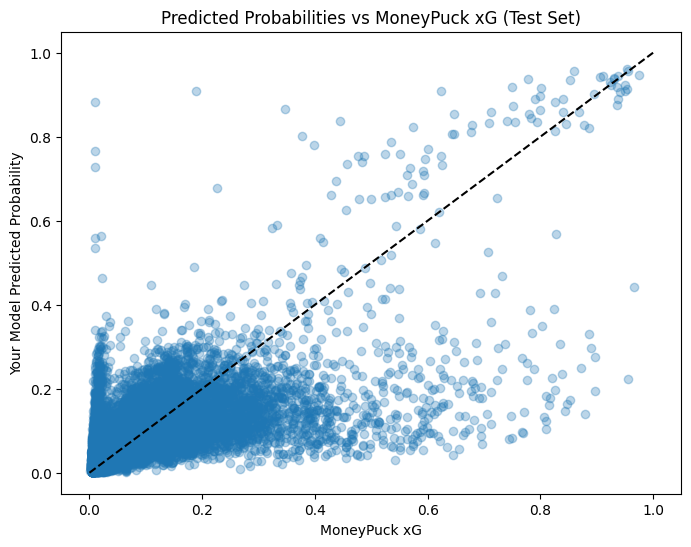

In [14]:
# compare to MoneyPuck's xGoal model
# Get the corresponding xGoal values for the test set
xgoal_test = df_combined.loc[X_test_enc.index, 'xGoal']

# Now plot
plt.figure(figsize=(8,6))
plt.scatter(xgoal_test, y_prob, alpha=0.3)
plt.plot([0,1], [0,1], 'k--')  # diagonal reference
plt.xlabel("MoneyPuck xG")
plt.ylabel("Your Model Predicted Probability")
plt.title("Predicted Probabilities vs MoneyPuck xG (Test Set)")
plt.show()

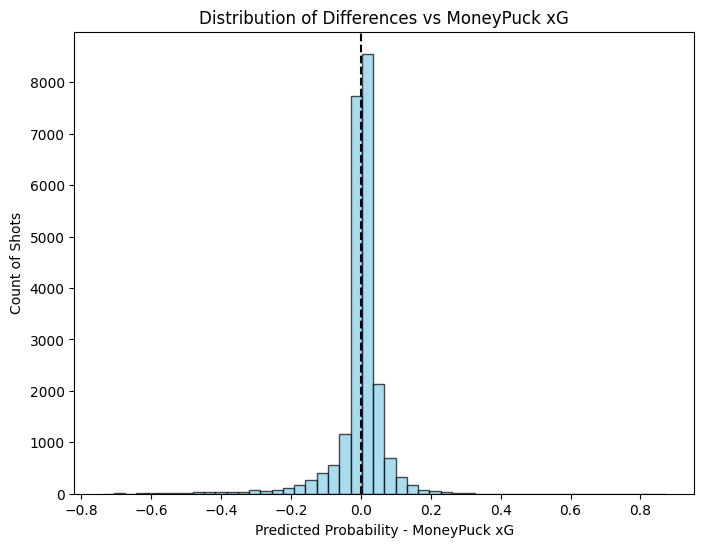

In [15]:
# plot absolute difference vs MoneyPuck
diff = y_prob - xgoal_test
abs_diff = np.abs(diff)

plt.figure(figsize=(8,6))
plt.hist(diff, bins=50, alpha=0.7, color='skyblue', edgecolor='k')
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("Predicted Probability - MoneyPuck xG")
plt.ylabel("Count of Shots")
plt.title("Distribution of Differences vs MoneyPuck xG")
plt.show()

Feature Importance- Combined Model

                         Feature  Coefficient  AbsCoefficient
11           shooter_scoring_pct     9.318065        9.318065
14               goalie_save_pct    -4.544992        4.544992
9                 shotOnEmptyNet     1.840363        1.840363
37  playerPositionThatDidEvent_G    -0.752649        0.752649
16                 shotType_SLAP     0.751011        0.751011
17                 shotType_SNAP     0.721410        0.721410
19                 shotType_WRAP    -0.713801        0.713801
26                 situation_4v6    -0.569726        0.569726
30                 situation_5v6    -0.563589        0.563589
33                 situation_6v5    -0.511473        0.511473
29                 situation_5v5    -0.475556        0.475556
24                 situation_4v4    -0.462708        0.462708
20                shotType_WRIST     0.382641        0.382641
28                 situation_5v4    -0.365905        0.365905
18                  shotType_TIP    -0.365676        0.365676


<Figure size 800x600 with 0 Axes>

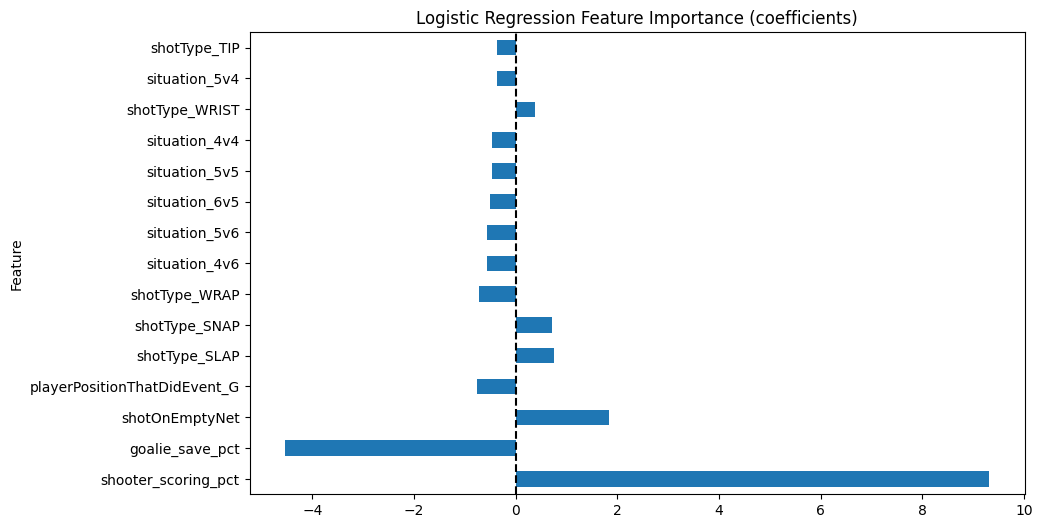

In [16]:
# Model coefficients

# Get feature names and coefficients
feature_names = X_train_enc.columns
coefs = model.coef_[0]  # Logistic regression coefficients

# Put into dataframe
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "AbsCoefficient": np.abs(coefs)
}).sort_values(by="AbsCoefficient", ascending=False)

# Display top features
print(coef_df.head(15))

# Plot top 15 features by absolute effect size
plt.figure(figsize=(8,6))
coef_df.head(15).plot(
    x="Feature", y="Coefficient", kind="barh", legend=False, figsize=(10,6)
)
plt.axvline(0, color="k", linestyle="--")
plt.title("Logistic Regression Feature Importance (coefficients)")
plt.show()

                         Feature  Importance       Std
3                   shotDistance    0.124227  0.002364
0                  xCordAdjusted    0.084457  0.001797
14               goalie_save_pct    0.001370  0.000221
9                 shotOnEmptyNet    0.000833  0.000173
30                 situation_5v6    0.000428  0.000017
11           shooter_scoring_pct    0.000279  0.000111
16                 shotType_SLAP    0.000227  0.000140
33                 situation_6v5    0.000183  0.000026
17                 shotType_SNAP    0.000122  0.000148
2              shotAngleAdjusted    0.000105  0.000029
32                 situation_6v4    0.000087  0.000000
7      timeDifferenceSinceChange    0.000065  0.000049
36  playerPositionThatDidEvent_D    0.000052  0.000101
37  playerPositionThatDidEvent_G    0.000044  0.000000
26                 situation_4v6    0.000039  0.000013


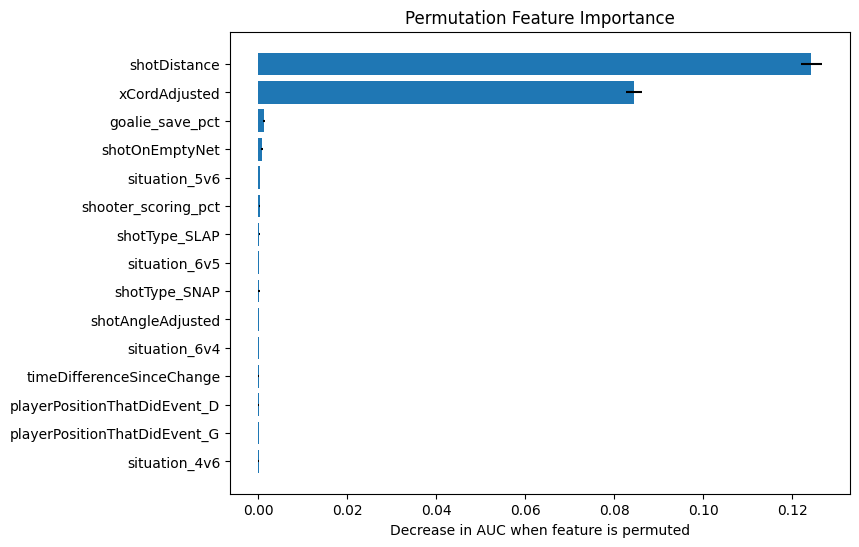

In [19]:
# Run permutation importance on test set
perm_importance = permutation_importance(model, X_test_enc, y_test, n_repeats=10, random_state=42)

# Put into dataframe
perm_df = pd.DataFrame({
    "Feature": X_test_enc.columns,
    "Importance": perm_importance.importances_mean,
    "Std": perm_importance.importances_std
}).sort_values(by="Importance", ascending=False)

# Show top 15
print(perm_df.head(15))

# Plot
plt.figure(figsize=(8,6))
plt.barh(perm_df["Feature"][:15], perm_df["Importance"][:15], xerr=perm_df["Std"][:15])
plt.gca().invert_yaxis()
plt.xlabel("Decrease in AUC when feature is permuted")
plt.title("Permutation Feature Importance")
plt.show()

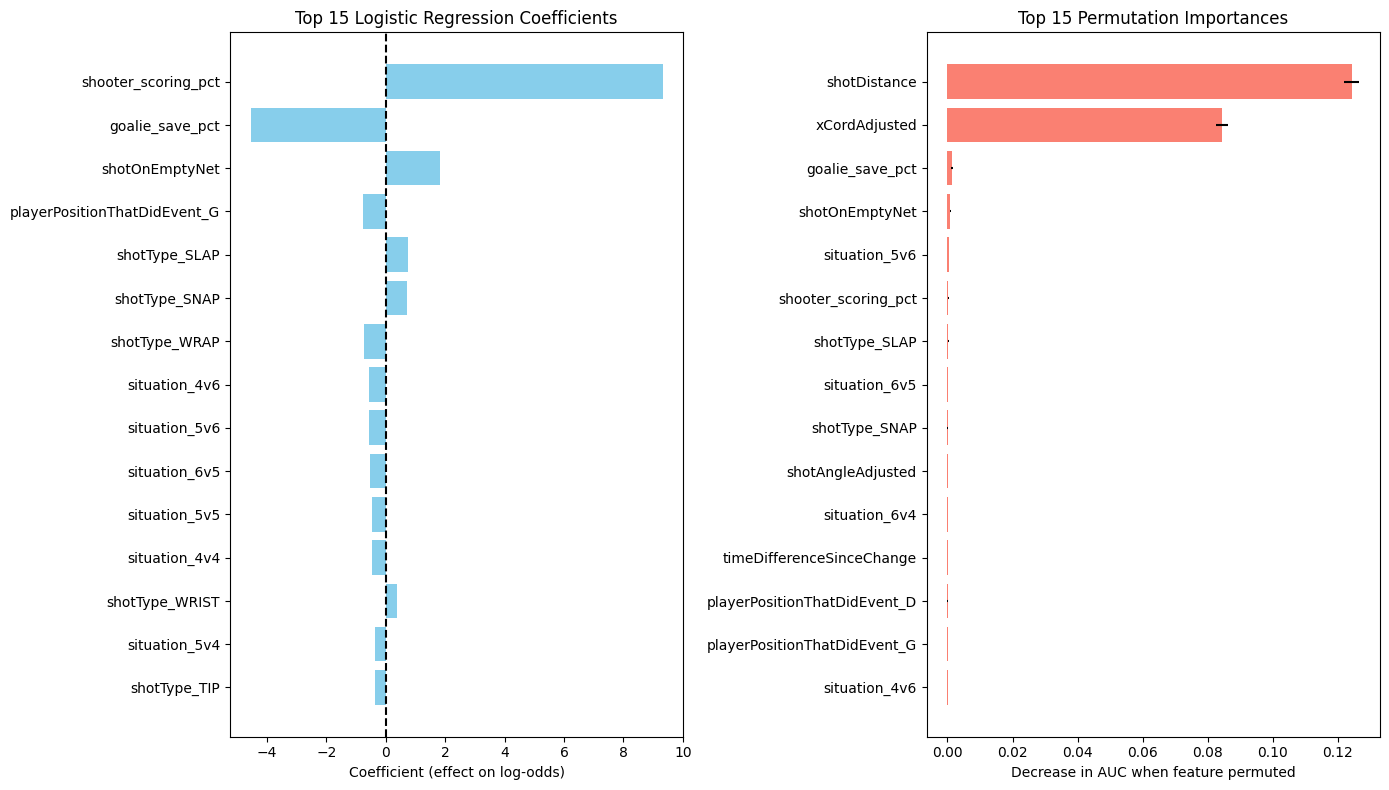

In [20]:
# side by side
# --- Prepare top features for coefficients ---
top_coef = coef_df.head(15).sort_values('AbsCoefficient')  # sort for horizontal bar chart

# --- Prepare top features for permutation importance ---
top_perm = perm_df.head(15).sort_values('Importance')  # sort for horizontal bar chart

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14,8))

# Logistic regression coefficients
axes[0].barh(top_coef['Feature'], top_coef['Coefficient'], color='skyblue')
axes[0].axvline(0, color='k', linestyle='--')
axes[0].set_title("Top 15 Logistic Regression Coefficients")
axes[0].set_xlabel("Coefficient (effect on log-odds)")

# Permutation importance
axes[1].barh(top_perm['Feature'], top_perm['Importance'], color='salmon', xerr=top_perm['Std'])
axes[1].set_title("Top 15 Permutation Importances")
axes[1].set_xlabel("Decrease in AUC when feature permuted")

plt.tight_layout()
plt.show()